# import 

In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# main

In [128]:
path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\"

In [388]:
# set variables 
n = 0
# delta/spindle power cross correlations
spindle_z_x_corr,spindle_z_temporal_shuffle,spindle_z_phase_shuffle = [], [], []
delta_z_x_corr,delta_z_temporal_shuffle,delta_z_phase_shuffle = [],[],[]
spectral_power_time_lags = []
# spindle events cross correlations
spindle_events_z_x_corr_replay,spindle_events_z_temporal_shuffle_replay,spindle_events_z_phase_shuffle_replay,spindle_events_time_lags_replay = [],[],[],[]
# linkage data
spindle_linkage_distance,spindle_linkage_distance_random_replay,spindle_linkage_distance_random_spindles = [],[],[]
#psth data
event_by_event_zscored_psth_spindles,event_by_event_psth_spindle_bins,event_by_event_zscored_psth_replay,event_by_event_psth_replay_bins = [],[],[],[]

for index, mouse_file in enumerate(os.listdir(path)):
    current_mouse_p = os.path.join(path, mouse_file)
    if 'analysis' in os.listdir(current_mouse_p):
        current_mouse_path = os.path.join(current_mouse_p, r"analysis\\")
        
        # add to the n
        n= n+1
        
        # load data for cross correlations
        # delta power data 
        delta_z_x_corr += [np.load(current_mouse_path + 'delta_z_x_corr.npy', allow_pickle=True)]
        delta_z_temporal_shuffle += [np.load(current_mouse_path + 'delta_z_temporal_shuffle.npy', allow_pickle=True)]
        delta_z_phase_shuffle += [np.load(current_mouse_path + 'delta_z_phase_shuffle.npy', allow_pickle=True)]
        # spindle power data 
        aa_spindle_z_x_corr += [np.load(current_mouse_path + 'spindle_z_x_corr.npy', allow_pickle=True)]
        spindle_z_temporal_shuffle += [np.load(current_mouse_path + 'spindle_z_temporal_shuffle.npy', allow_pickle=True)]
        spindle_z_phase_shuffle += [np.load(current_mouse_path + 'spindle_z_phase_shuffle.npy', allow_pickle=True)]
        
        spectral_power_time_lags += [np.load(current_mouse_path + 'spectral_power_time_lags.npy', allow_pickle=True)]

        # individual spindle occurance cross correlation        
        spindle_events_z_x_corr_replay += [np.load(current_mouse_path + 'spindle_events_z_x_corr_replay.npy')]
        spindle_events_z_temporal_shuffle_replay += [np.load(current_mouse_path + 'spindle_events_z_temporal_shuffle_replay.npy')]
        spindle_events_z_phase_shuffle_replay += [np.load(current_mouse_path + 'spindle_events_z_phase_shuffle_replay.npy')]
        spindle_events_time_lags_replay += [np.load(current_mouse_path + 'spindle_events_time_lags_replay.npy')]
        
        # spindle linkage analysis 
        spindle_linkage_distance += [np.load(current_mouse_path + 'spindle_linkage_distance.npy')]
        spindle_linkage_distance_random_replay += [np.load(current_mouse_path + 'spindle_linkage_distance_random_replay.npy')]
        spindle_linkage_distance_random_spindles += [np.load(current_mouse_path + 'spindle_linkage_distance_random_spindles.npy')]
        
        ## psth data
        event_by_event_zscored_psth_spindles += [np.load(current_mouse_path + 'event_by_event_zscored_psth_spindles.npy')]
        event_by_event_psth_spindle_bins += [np.load(current_mouse_path + 'event_by_event_psth_spindle_bins.npy')]
        event_by_event_zscored_psth_replay += [np.load(current_mouse_path + 'event_by_event_zscored_psth_replay.npy')]
        event_by_event_psth_replay_bins += [np.load(current_mouse_path + 'event_by_event_psth_replay_bins.npy')]
            

            
        
        


# power band cross correlations

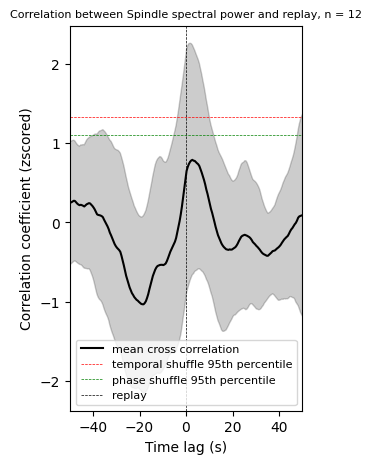

In [152]:
## plot cross correlations DELTA POWER

mean_delta_x_corr = np.mean(delta_z_x_corr,axis=0)
std_delta_x_corr = np.std(delta_z_x_corr,axis=0)
mean_delta_temporal_shuffle = np.mean(delta_z_temporal_shuffle,axis=0)
str_delta_temporal_shuffle = np.std(delta_z_temporal_shuffle,axis=0)
mean_delta_phase_shuffle = np.mean(delta_z_phase_shuffle,axis=0)
std_delta_phase_shuffle = np.std(delta_z_phase_shuffle,axis=0)

time_lags = np.mean(spectral_power_time_lags,axis=0)

fig, ax = plt.subplots(figsize=(3, 5))

ax.plot(time_lags,mean_delta_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_delta_x_corr - std_delta_x_corr, mean_delta_x_corr + std_delta_x_corr, alpha=0.2, color='k')

# get 95th percentile of shuffle data
mean_spin_events_temporal_shuffle_95 = np.percentile(mean_delta_temporal_shuffle, 95)
mean_spin_events_phase_shuffle_95 = np.percentile(mean_delta_phase_shuffle, 95)
ax.axhline(mean_spin_events_temporal_shuffle_95, color='red', lw=0.5, ls='--', label = 'temporal shuffle 95th percentile')
ax.axhline(mean_spin_events_phase_shuffle_95, color='green', lw=0.5, ls='--', label = 'phase shuffle 95th percentile')

# ax.plot(time_lags,mean_delta_temporal_shuffle, label='mean temporal shuffle', color='red')
# ax.fill_between(time_lags, mean_delta_temporal_shuffle - str_delta_temporal_shuffle, mean_delta_temporal_shuffle + str_delta_temporal_shuffle, alpha=0.2, color='red')

# ax.plot(time_lags,mean_delta_phase_shuffle, label='mean phase shuffle', color='green')
# ax.fill_between(time_lags, mean_delta_phase_shuffle - std_delta_phase_shuffle, mean_delta_phase_shuffle + std_delta_phase_shuffle, alpha=0.2, color='green')

ax.axvline(0, color='black', lw=0.5, ls='--', label = 'replay')
ax.set_xlabel('Time lag (s)', size = 10)
ax.set_ylabel('Correlation coefficient (zscored)', size = 10)
ax.set_title(f'Correlation between Spindle spectral power and replay, n = {n}', fontsize = 8)
ax.set_xlim(-50,50)
ax.legend(loc='lower right', fontsize=8)

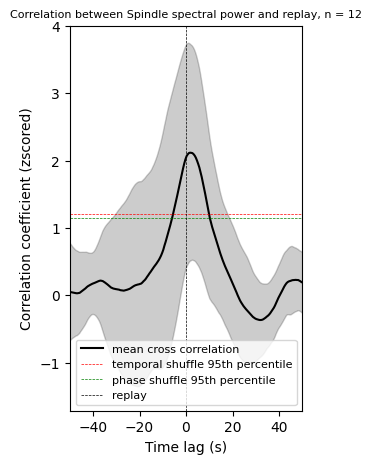

In [153]:
## plot cross correlations SPINDLE POWER

mean_spin_x_corr = np.mean(aa_spindle_z_x_corr,axis=0)
std_spin_x_corr = np.std(aa_spindle_z_x_corr,axis=0)
mean_spin_temporal_shuffle = np.mean(spindle_z_temporal_shuffle,axis=0)
str_spindle_temporal_shuffle = np.std(spindle_z_temporal_shuffle,axis=0)
mean_spin_phase_shuffle = np.mean(spindle_z_phase_shuffle,axis=0)
std_spin_phase_shuffle = np.std(spindle_z_phase_shuffle,axis=0)

time_lags = np.mean(spectral_power_time_lags,axis=0)

fig, ax = plt.subplots(figsize=(3, 5))

ax.plot(time_lags,mean_spin_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_spin_x_corr - std_spin_x_corr, mean_spin_x_corr + std_spin_x_corr, alpha=0.2, color='k')

# get 95th percentile of shuffle data
mean_spin_events_temporal_shuffle_95 = np.percentile(mean_spin_temporal_shuffle, 95)
mean_spin_events_phase_shuffle_95 = np.percentile(mean_spin_phase_shuffle, 95)
ax.axhline(mean_spin_events_temporal_shuffle_95, color='red', lw=0.5, ls='--', label = 'temporal shuffle 95th percentile')
ax.axhline(mean_spin_events_phase_shuffle_95, color='green', lw=0.5, ls='--', label = 'phase shuffle 95th percentile')

# ax.plot(time_lags,mean_spin_temporal_shuffle, label='mean temporal shuffle', color='red')
# ax.fill_between(time_lags, mean_spin_temporal_shuffle - str_spindle_temporal_shuffle, mean_spin_temporal_shuffle + str_spindle_temporal_shuffle, alpha=0.2, color='red')

# ax.plot(time_lags,mean_spin_phase_shuffle, label='mean phase shuffle', color='green')
# ax.fill_between(time_lags, mean_spin_phase_shuffle - std_spin_phase_shuffle, mean_spin_phase_shuffle + std_spin_phase_shuffle, alpha=0.2, color='green')

ax.axvline(0, color='black', lw=0.5, ls='--', label = 'replay')
ax.set_xlabel('Time lag (s)', size = 10)
ax.set_ylabel('Correlation coefficient (zscored)', size = 10)
ax.set_title(f'Correlation between Spindle spectral power and replay, n = {n}', fontsize = 8)
ax.set_xlim(-50,50)
ax.legend(loc='lower right', fontsize=8)

# individual spindle occurance cross correlation

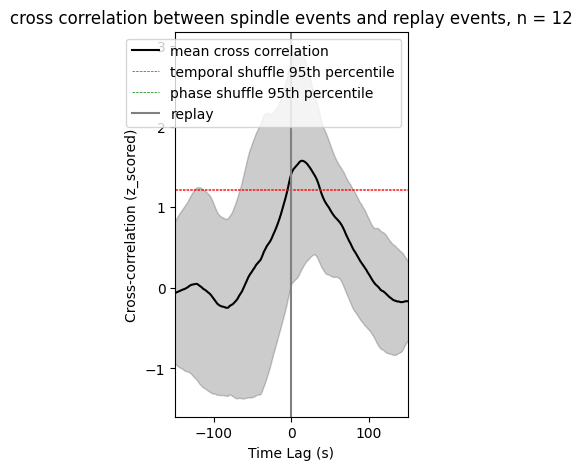

In [381]:


mean_spin_events_x_corr = np.mean(spindle_events_z_x_corr_replay,axis=0)
std_spin_events_x_corr = np.std(spindle_events_z_x_corr_replay,axis=0)
mean_spin_events_temporal_shuffle = np.mean(spindle_events_z_temporal_shuffle_replay,axis=0)
str_spindle_events_temporal_shuffle = np.std(spindle_events_z_temporal_shuffle_replay,axis=0)
mean_spin_events_phase_shuffle = np.mean(spindle_events_z_phase_shuffle_replay,axis=0)
std_spin_events_phase_shuffle = np.std(spindle_events_z_phase_shuffle_replay,axis=0)

# i = 4
# mean_spin_events_x_corr = spindle_events_z_x_corr_replay[i]
# std_spin_events_x_corr = np.std(spindle_events_z_x_corr_replay[i])
# mean_spin_events_temporal_shuffle = spindle_events_z_temporal_shuffle_replay[i]
# str_spindle_events_temporal_shuffle = np.std(spindle_events_z_temporal_shuffle_replay[i])
# mean_spin_events_phase_shuffle = spindle_events_z_phase_shuffle_replay[i]
# std_spin_events_phase_shuffle = np.std(spindle_events_z_phase_shuffle_replay[i])


time_lags = np.mean(spindle_events_time_lags_replay,axis=0)

fig, ax = plt.subplots(figsize=(3, 5))

ax.plot(time_lags,mean_spin_events_x_corr, label='mean cross correlation', color='k')
ax.fill_between(time_lags, mean_spin_events_x_corr - std_spin_events_x_corr, mean_spin_events_x_corr + std_spin_events_x_corr, alpha=0.2, color='k')

# get 95th percentile of shuffle data
mean_spin_events_temporal_shuffle_95 = np.percentile(mean_spin_events_temporal_shuffle, 95)
mean_spin_events_phase_shuffle_95 = np.percentile(mean_spin_events_phase_shuffle, 95)
ax.axhline(mean_spin_events_temporal_shuffle_95, color='red', lw=0.5, ls='--', label = 'temporal shuffle 95th percentile')
ax.axhline(mean_spin_events_phase_shuffle_95, color='green', lw=0.5, ls='--', label = 'phase shuffle 95th percentile')

# ax.plot(time_lags,mean_spin_events_temporal_shuffle, label='mean temporal shuffle', color='red')
# ax.fill_between(time_lags, mean_spin_events_temporal_shuffle - str_spindle_events_temporal_shuffle, mean_spin_events_temporal_shuffle + str_spindle_events_temporal_shuffle, alpha=0.2, color='red')

# ax.plot(time_lags,mean_spin_events_phase_shuffle, label='mean phase shuffle', color='green')
# ax.fill_between(time_lags, mean_spin_events_phase_shuffle - std_spin_events_phase_shuffle, mean_spin_events_phase_shuffle + std_spin_events_phase_shuffle, alpha=0.2, color='green')
ax.set_xlim(-150,150)
ax.axvline(0,color = 'grey', label = 'replay')
ax.set_xlabel('Time Lag (s)')
ax.set_ylabel('Cross-correlation (z_scored)')
ax.set_title(f'cross correlation between spindle events and replay events, n = {n}')
ax.legend()

# Linkage analysis - Time Lag from replay to closest spindle

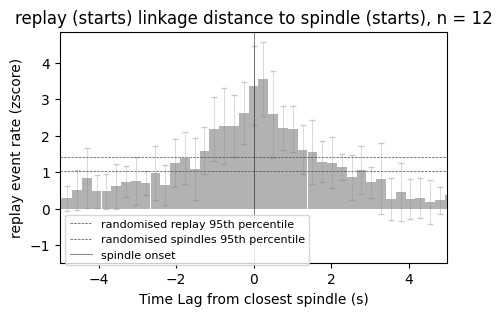

In [386]:
import scipy 
def bin_and_normalise(spindle_linkage_distance,bins):
    normed_x_all = []
    for i in range(len(spindle_linkage_distance)):
        x = plt.hist(spindle_linkage_distance[i],bins)
        plt.close()
        # normed_x_all += [x[0]/sum(x[0])]
        normed_x_all += [scipy.stats.zscore(x[0])]
    return normed_x_all

# bin between 
bins_ = 160
bins = np.linspace(-20,20,bins_)
bin_centres = np.linspace(-20,20,bins_ -1 )

# flip bin centres around : because currently it is calculated so that negative means
bin_centres = np.flip(bin_centres,axis=0)

spindle_linkage_distance_binned = bin_and_normalise(spindle_linkage_distance,bins)
spindle_linkage_distance_binned_random_replay = bin_and_normalise(spindle_linkage_distance_random_replay,bins)
spindle_linkage_distance_binned_random_spindles = bin_and_normalise(spindle_linkage_distance_random_spindles,bins)

mean_spindle_linkage_distance = np.mean(spindle_linkage_distance_binned,axis = 0)
std_spindle_linkage_distance = np.std(spindle_linkage_distance_binned,axis = 0)
mean_spindle_linkage_distance_random_replay = np.mean(spindle_linkage_distance_binned_random_replay,axis = 0)
std_spindle_linkage_distance_random_replay = np.std(spindle_linkage_distance_binned_random_replay,axis = 0)
mean_spindle_linkage_distance_random_spindles = np.mean(spindle_linkage_distance_binned_random_spindles,axis = 0)
std_spindle_linkage_distance_random_spindles = np.std(spindle_linkage_distance_binned_random_spindles,axis = 0)

fig,ax,= plt.subplots(1, 1,figsize=(5, 3))

# Compute bin centers for bar plot
widths = np.diff(bins)

# Error bar style
error_style = dict(ecolor='grey', elinewidth=0.5, capsize=2, alpha = 0.4)
ax.bar(bin_centres, mean_spindle_linkage_distance, width=widths, yerr=std_spindle_linkage_distance,align='center', alpha = 0.6, color = 'grey', error_kw=error_style)

#95th percentile of the random data
mean_spindle_linkage_distance_random_replay_95 = np.percentile(mean_spindle_linkage_distance_random_replay, 95)
ax.axhline(mean_spindle_linkage_distance_random_replay_95, color='red', lw=0.5, ls='--', label = 'randomised replay 95th percentile')
#95th percentile of the random data
mean_spindle_linkage_distance_random_spindles_95 = np.percentile(mean_spindle_linkage_distance_random_spindles, 95)
ax.axhline(mean_spindle_linkage_distance_random_spindles_95, color='green', lw=0.5, ls='--', label = 'randomised spindles 95th percentile')

ax.set_xlabel('Time Lag from closest spindle (s)')
ax.set_ylabel('replay event rate (zscore)')
ax.set_title(f'replay (starts) linkage distance to spindle (starts), n = {n}')
ax.axvline(0,color = 'k', alpha = 0.7, label = 'spindle onset', linewidth = 0.5)
ax.set_xlim(-5,5)
ax.legend(loc='center left', bbox_to_anchor=(0, 0.1), fontsize = 8)




# PSTHs for spindles and replay

In [ ]:
# some stuff here might be wrong - check the timing and the confidence intervals! 

(-20.0, 20.0)

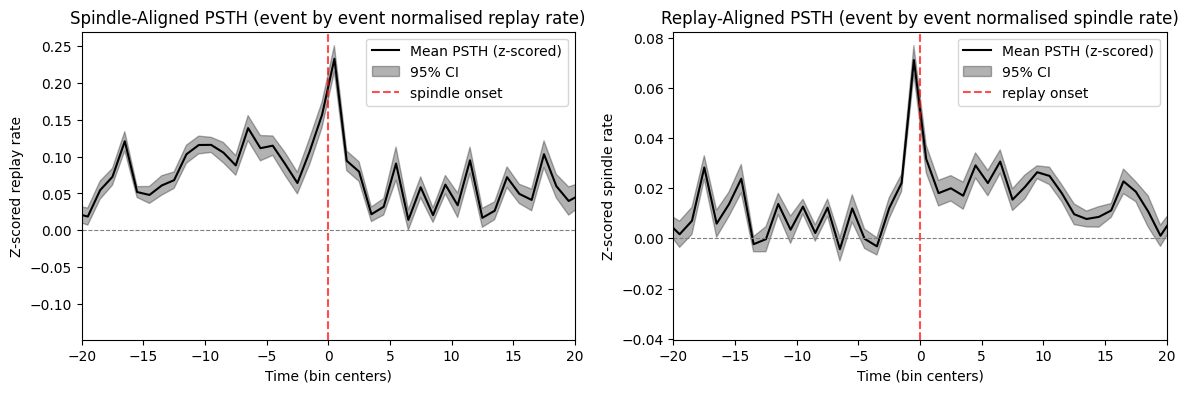

In [407]:
items = []
for item in event_by_event_zscored_psth_spindles:
    items +=[np.nanmean(item,axis=0)]
    
mean_psth_spin = np.nanmean(items, axis=0)
std_psth_spin = np.nanstd(items, axis=0)
n_trials_spin = len(np.nanmean(items,axis=0))
stderr_psth_spin = std_psth_spin / np.sqrt(n_trials_spin)
# Compute 95% confidence intervals
ci95_upper_spin = mean_psth_spin + 1.96 * stderr_psth_spin
ci95_lower_spin = mean_psth_spin - 1.96 * stderr_psth_spin

# Plotting
fig,[ax,ax2]= plt.subplots(1, 2,figsize=(14, 4))
ax.plot(event_by_event_psth_spindle_bins[0], mean_psth_spin, label='Mean PSTH (z-scored)', color='k')
ax.fill_between(event_by_event_psth_spindle_bins[0], ci95_lower_spin, ci95_upper_spin, alpha=0.3, color='k', label='95% CI')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0,color = 'red',linestyle='--', alpha = 0.7, label = 'spindle onset')
ax.set_xlabel('Time (bin centers)')
ax.set_ylabel('Z-scored replay rate')
ax.set_title('Spindle-Aligned PSTH (event by event normalised replay rate)')
ax.legend()
ax.set_xlim(-20,20)


#### same again but inverse

items = []
for item in event_by_event_zscored_psth_replay:
    items +=[np.nanmean(item,axis=0)]
mean_psth_rply = np.nanmean(items, axis=0)
std_psth_rply = np.nanstd(items, axis=0)
n_trials_rply = len(np.nanmean(items,axis=0))

stderr_psth_rply = std_psth_rply / np.sqrt(n_trials_rply)
# Compute 95% confidence intervals
ci95_upper_rply = mean_psth_rply + 1.96 * stderr_psth_rply
ci95_lower_rply = mean_psth_rply - 1.96 * stderr_psth_rply

# Plotting

ax2.plot(event_by_event_psth_replay_bins[0], mean_psth_rply, label='Mean PSTH (z-scored)', color='k')
ax2.fill_between(event_by_event_psth_replay_bins[0], ci95_lower_rply, ci95_upper_rply, alpha=0.3, color='k', label='95% CI')
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax2.axvline(0,color = 'red',linestyle='--', alpha = 0.7, label = 'replay onset')
ax2.set_xlabel('Time (bin centers)')
ax2.set_ylabel('Z-scored spindle rate')
ax2.set_title('Replay-Aligned PSTH (event by event normalised spindle rate)')
ax2.legend()
ax2.set_xlim(-20,20)

# spindle amplitude + magnitude vs proximity to replay 
also plot average feature size near replay vs far from replay

# average event triggered average

#

In [ ]:
#plot cross correlation average across mice


In [ ]:
spindle_z_x_corr

array([-9.22753886e-01, -9.85426433e-01, -1.04851484e+00, -1.10616168e+00,
       -1.16181183e+00, -1.20768744e+00, -1.24310011e+00, -1.26912946e+00,
       -1.29862751e+00, -1.32267908e+00, -1.33093902e+00, -1.32554304e+00,
       -1.30811170e+00, -1.27467972e+00, -1.24119186e+00, -1.19874186e+00,
       -1.14326794e+00, -1.07501007e+00, -1.00286507e+00, -9.26731014e-01,
       -8.49731931e-01, -7.72120994e-01, -6.87548511e-01, -6.07507715e-01,
       -5.29200881e-01, -4.44868049e-01, -3.65008107e-01, -2.76898515e-01,
       -1.85972750e-01, -9.66873579e-02, -1.65353170e-02,  5.67612776e-02,
        1.19969680e-01,  1.76750740e-01,  2.36114843e-01,  2.93746284e-01,
        3.45191084e-01,  3.93896955e-01,  4.51406525e-01,  5.04748430e-01,
        5.73166449e-01,  6.39624451e-01,  7.09726248e-01,  7.74916092e-01,
        8.39809112e-01,  8.88502686e-01,  9.32994343e-01,  9.68958637e-01,
        1.00785621e+00,  1.04175451e+00,  1.07892810e+00,  1.11930282e+00,
        1.15759334e+00,  

In [ ]:
    #save out the data
    np.save(output_path + 'delta_z_x_corr.npy',delta_z_x_corr)
    np.save(output_path + 'delta_z_temporal_shuffle.npy',delta_z_temporal_shuffle)
    np.save(output_path + 'delta_z_phase_shuffle.npy',delta_z_phase_shuffle)
    np.save(output_path + 'spindle_z_x_corr.npy',spindle_z_x_corr)
    np.save(output_path + 'spindle_z_temporal_shuffle.npy',spindle_z_temporal_shuffle)
    np.save(output_path + 'spindle_z_phase_shuffle.npy',spindle_z_phase_shuffle)

In [22]:
os.listdir(current_mouse_path)

['average_signal.npy',
 'average_signal_rect.npy',
 'chunk_spind_av_magnitudes.npy',
 'chunk_spind_lengths.npy',
 'chunk_spind_peaks.npy',
 'chunk_spind_total_magnitude.npy',
 'cross_correlation_delta_spindle_replay.png',
 'delta_spectral_power_vs_replay.png',
 'delta_z_phase_shuffle.npy',
 'delta_z_temporal_shuffle.npy',
 'delta_z_x_corr.npy',
 'distance_to_replay.npy',
 'event_by_event_psth_replay_bins.npy',
 'event_by_event_psth_spindle_bins.npy',
 'event_by_event_zscored_psth_replay.npy',
 'event_by_event_zscored_psth_spindles.npy',
 'peak_algined_average_signal.npy',
 'peak_sems.npy',
 'PSTH_event_by_event.png',
 'random_average_signal.npy',
 'random_average_signal_rect.npy',
 'random_peak_algined_average_signal.npy',
 'random_peak_sems.npy',
 'spindle_features_vs_distance_to_replay.png',
 'spindle_identification.png',
 'spindle_linkage_distance.npy',
 'spindle_linkage_distance.png',
 'spindle_linkage_distance_random_replay.npy',
 'spindle_linkage_distance_random_spindles.npy',
 '

'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\oscillations\\striatum_lfp\\expert\\\\seq008_1_3\\analysis'